In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 

from sklearn.model_selection import train_test_split
from scipy import stats

from multiprocessing import cpu_count

# Categorías intocables

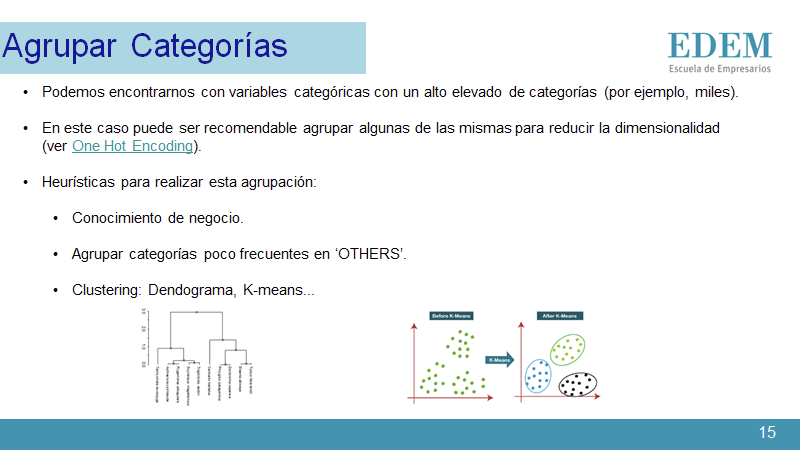

Agrupar categorías puede ser un paso de preprocesamiento realmente útil. Sin embargo, agrupar todas las categorías menos frecuentes en una única miscelánea puede hacer que se pierda información realmente útil.

Por ejemplo, un diagnóstico particular puede ser raro, pero puede tener un ratio de exitus extremadamente alto, lo que significa que esta categoría podría ser realmente útil para predecir la mortalidad.

Intentemos aquí marcar algunas categorías como *tocables* en cuanto a agrupación de categorías por su especial relación con el objetivo.

## Load Data

In [2]:
dat = pd.read_csv("../datasets/i2.csv", sep = ";")
dat

,user,booking_date,origin_airport,price,sales channel,ant,airline
0,user5,01/11/2018,MAD,NaN,online,NaN,i2
1,user7,01/11/2018,DUB,147.500000,online,38.0,i2
2,user4,02/11/2018,TFS,24.049999,online,19.0,i2
3,user8,29/10/2018,MAD,59.709999,online,8.0,i2
4,user7,01/11/2018,NaN,37.299999,call center,4.0,i2
...,...,...,...,...,...,...,...
995,user2,01/11/2018,JMK,NaN,online,29.0,i2
996,user10,01/11/2018,SVQ,NaN,online,39.0,i2
997,user4,30/10/2018,MAD,NaN,online,5.0,i2
998,user10,02/11/2018,CDG,NaN,online,4.0,i2


## Comprobar los ratios objetivo por categoría

Imaginemos que queremos predecir el *canal de ventas*. Vamos a un problema de clasificación binaria para simplificar.

In [3]:
dat = dat[dat['sales channel'] != 'travel agency']

Podemos calcular la proporción de canal de ventas para cada categoría de las otras columnas. Empecemos por *user*.

In [4]:
target = 'sales channel'
ratios = dat.groupby(['user'])[target].apply(lambda x:100*x.value_counts()/x.size)
ratios

user               
user1   online         93.243243
        call center     6.756757
user10  online         90.277778
        call center     9.722222
user2   online         98.333333
        call center     1.666667
user3   online         95.588235
        call center     4.411765
user4   online         96.969697
        call center     3.030303
user5   online         94.736842
        call center     5.263158
user6   online         96.969697
        call center     3.030303
user7   online         90.769231
        call center     9.230769
user8   online         93.548387
        call center     6.451613
user9   online         91.780822
        call center     8.219178
Name: sales channel, dtype: float64

In [5]:
users = ratios.index.get_level_values('user').unique()
ratios = ratios.reorder_levels([None,'user']).sort_index()

Centrémonos en la clase minoritaria.

In [6]:
ratios = ratios[['call center']].values
ratios

array([6.75675676, 9.72222222, 1.66666667, 4.41176471, 3.03030303,
       5.26315789, 3.03030303, 9.23076923, 6.4516129 , 8.21917808])

Calculamos su media y su desviación típica.

In [7]:
mu = np.mean(ratios)
sd = np.std(ratios)
print('mu = %.2f and sd = %.2f' % (mu, sd))

mu = 5.78 and sd = 2.63


Vamos a crear unos intervalos de confianza.

In [8]:
anomaly_coefficent = 1
lower = mu - anomaly_coefficent*sd
upper = mu + anomaly_coefficent*sd
print('lower = %.2f and upper = %.2f' % (lower, upper))

lower = 3.15 and upper = 8.40


Cualquier categoría fuera de ese intervalo de confianza se marcaría como *intocable*.

In [9]:
untouchable_values = users[np.logical_or(ratios < lower, ratios > upper)].values.tolist()
untouchable_values

['user10', 'user2', 'user4', 'user6', 'user7']

Poniéndolo todo junto.

In [10]:
target = 'sales channel'
anomaly_coefficent = 1

column = 'user'
ratios = dat.groupby([column])[target].apply(lambda x:100*x.value_counts().reindex(dat[target].unique(), fill_value=0)/x.size)
users = ratios.index.get_level_values(column).unique()
ratios = ratios.reorder_levels([None,column]).sort_index()
ratios = ratios[['call center']].values # Generic! Extract minority automatically

# Anomaly (assuming normality)
mu = np.mean(ratios)
sd = np.std(ratios)
lower = mu - anomaly_coefficent*sd
upper = mu + anomaly_coefficent*sd
untouchable_values = users[np.logical_or(ratios < lower,  ratios > upper)].values.tolist()
untouchable_values

['user10', 'user2', 'user4', 'user6', 'user7']

Vamos a crear una función.

In [11]:
def untouchable_values(dat, column, target, anomaly_coefficent = 3):
    ratios = dat.groupby([column])[target].apply(lambda x:100*x.value_counts().reindex(dat[target].unique(), fill_value=0)/x.size)
    users = ratios.index.get_level_values(column).unique()
    ratios = ratios.reorder_levels([None,column]).sort_index()
    ratios = ratios[['call center']].values # Generic!
    mu = np.mean(ratios)
    sd = np.std(ratios)
    lower = mu - anomaly_coefficent*sd
    upper = mu + anomaly_coefficent*sd
    untouchable_values = users[np.logical_or(ratios < lower,  ratios > upper)].values.tolist()
    return untouchable_values

In [12]:
untouchable_values(dat, 
                   target = 'sales channel',
                   anomaly_coefficent = 1,
                   column = 'user')

['user10', 'user2', 'user4', 'user6', 'user7']

In [13]:
untouchable_values(dat, 
                   target = 'sales channel',
                   anomaly_coefficent = 2,
                   column = 'user')

[]

Ahora, utilicémoslo para todas las variables categóricas utilizando un diccionario.

In [18]:
categorical_variables = dat.columns[dat.dtypes == object ].tolist()
d = {}
for c in categorical_variables:
    d[c] = untouchable_values(dat, 
                   target = 'sales channel',
                   anomaly_coefficent = 1.96,
                   column = c)
d

{'user': [],
 'booking_date': [],
 'origin_airport': ['BHX', 'CWB'],
 'sales channel': [],
 'airline': []}

## Definir Función

In [15]:
def untouchable_categories(X, target, anomaly_coefficent = 3):
    categorical_variables = X.columns[dat.dtypes == object].tolist()
    d = {}
    for c in categorical_variables:
        d[c] = untouchable_values(X, 
                       target = 'sales channel',
                       anomaly_coefficent = anomaly_coefficent,
                       column = c)
    return d
                                                                                        

In [19]:
untouchable = untouchable_categories(dat, target = 'sales channel', anomaly_coefficent = 1)
untouchable

{'user': ['user10', 'user2', 'user4', 'user6', 'user7'],
 'booking_date': ['03/11/2018', '29/10/2018'],
 'origin_airport': ['BHX', 'CWB', 'FUE', 'NTE', 'RNS'],
 'sales channel': [],
 'airline': []}

In [20]:
untouchable = untouchable_categories(dat, target = 'sales channel')
untouchable

{'user': [],
 'booking_date': [],
 'origin_airport': ['BHX', 'CWB'],
 'sales channel': [],
 'airline': []}